    Roman Peerboom  10791523
    Floris de Vries 11710799

In [1]:
import numpy
import simpy
import random
import statistics 
import time
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
## First in first out system with an exponential time in system distribution

def source(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = object(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)     # Time before new customer arrives
        yield env.timeout(t)
        
        
def object(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    with counter.request() as req:
        results = yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = random.expovariate(mu)
        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [3]:
n_s = [1, 2, 4]                              # Number of servers
simulations = 100
mean_waiting_times = [[],[],[]]

start_time = time.time()

for n_ind in range(len(n_s)):
    n = n_s[n_ind]
    lambda_1 = arrival_rate = n/15              # Arrival rate, n/(inter arrival time)
    time_in_system = 14                        # Mean time in system 
    mu = 1/time_in_system                      # How much people one server can help for a given time period 
    number_of_arrivals = 10000000000
    print("\N{greek small letter rho} is: " + str(lambda_1/(n*mu)) + " with lambda: " +
          str(lambda_1) + " & mu: " + str(mu) +  " for " + str(n) + " server(s).")
    for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
        waiting_times = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n) 
        env.process(source(env,number_of_arrivals,lambda_1, server, mu))
        env.run(until=1000000)
#         print("Average waiting time for this simulation: " + str(statistics.mean(waiting_times)))
        mean_waiting_times[n_ind].append(statistics.mean(waiting_times))    
    print("Average waiting time: " + str(statistics.mean(mean_waiting_times[n_ind])) +
          " with sd: " + str(statistics.stdev(mean_waiting_times[n_ind])) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 192.617253879132 with sd: 20.761102524103137

ρ is: 0.9333333333333333 with lambda: 0.13333333333333333 & mu: 0.07142857142857142 for 2 server(s).
Average waiting time: 92.60534837546952 with sd: 7.8554549095523605

ρ is: 0.9333333333333333 with lambda: 0.26666666666666666 & mu: 0.07142857142857142 for 4 server(s).
Average waiting time: 44.832678035345495 with sd: 3.017963959831067

Running time: 1628.4171295166016


In [139]:
## 95% CI
## The shapiro test for normality
## The Mann-Whitney U test for difference, because the distributions were not normal
for n_ind in range(len(mean_waiting_times)):
    print("Mean: " + str(statistics.mean(mean_waiting_times[n_ind])) +
          ". Upper limit: " + str(statistics.mean(mean_waiting_times[n_ind])+ 1.96*statistics.stdev(mean_waiting_times[n_ind])/len(mean_waiting_times[n_ind])**0.5) +
          ". Lower limit: " + str(statistics.mean(mean_waiting_times[n_ind])- 1.96*statistics.stdev(mean_waiting_times[n_ind])/len(mean_waiting_times[n_ind])**0.5) + "\n")

statistic_1server = scipy.stats.shapiro(mean_waiting_times[0])
print(statistic_1server)
statistic_2server = scipy.stats.shapiro(mean_waiting_times[1])
print(statistic_2server)
statistic_3server = scipy.stats.shapiro(mean_waiting_times[2])
print(statistic_3server)

print(scipy.stats.mannwhitneyu(mean_waiting_times[0], mean_waiting_times[1]))
print(scipy.stats.mannwhitneyu(mean_waiting_times[1], mean_waiting_times[2]))

Mean: 192.617253879132. Upper limit: 196.6864299738562. Lower limit: 188.54807778440778

Mean: 92.60534837546952. Upper limit: 94.14501753774178. Lower limit: 91.06567921319726

Mean: 44.832678035345495. Upper limit: 45.424198971472386. Lower limit: 44.241157099218604

ShapiroResult(statistic=0.972661554813385, pvalue=0.03545880690217018)
ShapiroResult(statistic=0.9435343146324158, pvalue=0.0003188191039953381)
ShapiroResult(statistic=0.9563524723052979, pvalue=0.002228413475677371)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)


C:\Users\flori\anaconda3\lib\site-packages\seaborn\axisgrid.py:923: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, **kwargs)


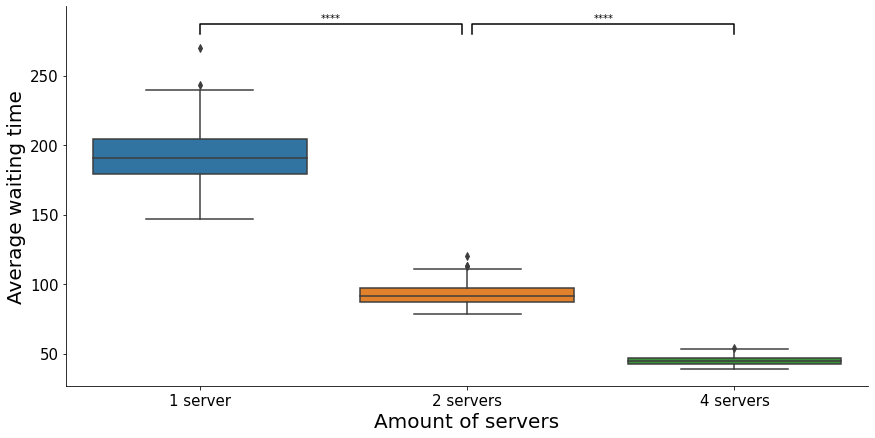

In [78]:
## Plotting the results as boxplots for different methods
df_1_server = pd.DataFrame({'Waiting time': mean_waiting_times[0], 'Method': ['1 server' for i in range(len(mean_waiting_times[0]))], 'Service rate distribution': ['Exponential' for i in range(len(mean_waiting_times[0]))]})
df_2_server = pd.DataFrame({'Waiting time': mean_waiting_times[1], 'Method': ['2 servers' for i in range(len(mean_waiting_times[1]))], 'Service rate distribution': ['Exponential' for i in range(len(mean_waiting_times[0]))]})
df_3_server = pd.DataFrame({'Waiting time': mean_waiting_times[2], 'Method': ['4 servers' for i in range(len(mean_waiting_times[2]))], 'Service rate distribution': ['Exponential' for i in range(len(mean_waiting_times[0]))]})
df_total = df_1_server.append(df_2_server)
df_total = df_total.append(df_3_server)

p = sns.catplot(x="Method", y="Waiting time", kind="box", data=df_total, height=6, aspect=12/6)

plt.xlabel("Amount of servers", size = 20)
plt.ylabel("Average waiting time", size = 20)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(ylabels, size=15)
p.set_xticklabels(xlabels, size=15)
# p.set(yscale="log")

x1, x2 = 0, 0.98   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = df_total['Waiting time'].max()+10, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

x3, x4 = 1.02, 2   # columns '2 server' and '4 server' (first column: 0, see plt.xticks())
y1, h1, col = df_total['Waiting time'].max() + 10, 7.5, 'k'
# y1, h1, col = 1, 0.25, 'k'
plt.plot([x3, x3, x4, x4], [y1, y1+h1, y1+h1, y1], lw=1.5, c=col)
plt.text((x3+x4)*.5, y1+h1, "****", ha='center', va='bottom', color=col)

plt.savefig('boxplots_server_amount.png', format='png', dpi=600, bbox_inches = "tight")


## FIFO versus priority ot the smallest job for 1 server

In [6]:
## Give priority to the smallest job

def source_prior(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = object_prior(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)
        yield env.timeout(t)
        
        
def object_prior(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    tib = random.expovariate(mu)
    with counter.request(priority = tib) as req:
        results = yield req
        wait = env.now - arrive
        waiting_times_priority.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [7]:
start_time = time.time()

n = 1                                       # Number of servers
lambda_1 = arrival_rate = n/15              # Arrival rate, events in given time period
time_in_system = 14                         # Mean time in system 
mu = 1/time_in_system                      # How much people one server can help for a given time period 
simulations = 100
number_of_arrivals = 10000000000
print("\N{greek small letter rho} is: " + str(lambda_1/(n*mu)) + " with lambda: " +
      str(lambda_1) + " & mu: " + str(mu) +  " for " + str(n) + " server(s).")

mean_waiting_times_priority = []
for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
    waiting_times_priority = []
    env = simpy.Environment()
    server = simpy.PriorityResource(env, capacity=n) 
    env.process(source_prior(env,number_of_arrivals,lambda_1, server, mu))
    env.run(until=1000000)
    mean_waiting_times_priority.append(statistics.mean(waiting_times_priority))    
print("Average waiting time: " + str(statistics.mean(mean_waiting_times_priority)) +
      " with sd: " + str(statistics.stdev(mean_waiting_times_priority)) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 59.8179147109432 with sd: 4.823470690664082

Running time: 246.91836643218994


In [141]:
print("Mean: " + str(statistics.mean(waiting_times_priority)) +
      ". Upper limit: " + str(statistics.mean(waiting_times_priority)+ 1.96*statistics.stdev(waiting_times_priority)/len(waiting_times_priority)**0.5) +
      ". Lower limit: " + str(statistics.mean(waiting_times_priority)- 1.96*statistics.stdev(waiting_times_priority)/len(waiting_times_priority)**0.5) + "\n")


statistic_1server_FIFO = scipy.stats.shapiro(mean_waiting_times[0])
print(statistic_1server)
statistic_1server_prior = scipy.stats.shapiro(mean_waiting_times_priority)
print(statistic_1server_prior)

print(scipy.stats.mannwhitneyu(mean_waiting_times[0], mean_waiting_times_priority))

Mean: 61.61027505080745. Upper limit: 64.45095851648614. Lower limit: 58.769591585128765

ShapiroResult(statistic=0.972661554813385, pvalue=0.03545880690217018)
ShapiroResult(statistic=0.9738414287567139, pvalue=0.04380549117922783)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)


C:\Users\flori\anaconda3\lib\site-packages\seaborn\axisgrid.py:923: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, **kwargs)


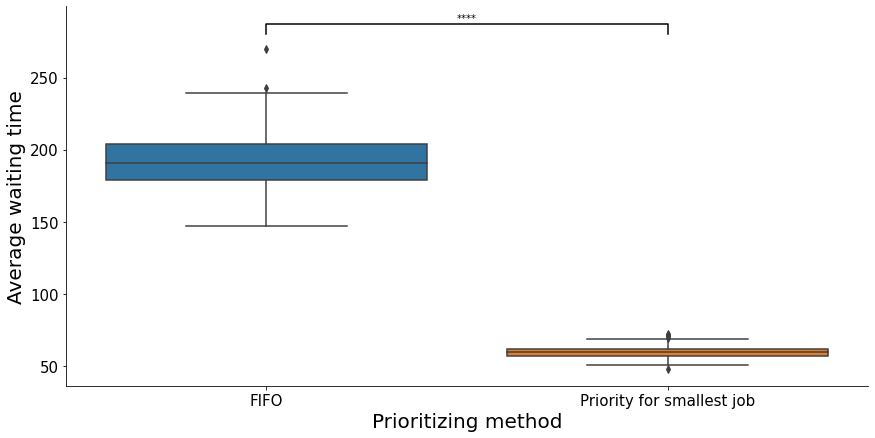

In [144]:
df_1_server_LOFF = pd.DataFrame({'Waiting time': mean_waiting_times[0], 'Method': ['FIFO' for i in range(len(mean_waiting_times[0]))]})
df_1_server_prior = pd.DataFrame({'Waiting time': mean_waiting_times_priority, 'Method': ['Priority for smallest job' for i in range(len(mean_waiting_times_priority))]})
df_total_1_server = df_1_server_LOFF.append(df_1_server_prior)

p = sns.catplot(x="Method", y="Waiting time", kind="box", data=df_total_1_server, height=6, aspect=12/6)

plt.xlabel("Prioritizing method", size = 20)
plt.ylabel("Average waiting time", size = 20)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(ylabels, size=15)
p.set_xticklabels(xlabels, size=15)
# p.set(yscale="log")

x1, x2 = 0, 1   # columns 'LOFF' and 'Priority' (first column: 0, see plt.xticks())
y, h, col = df_total['Waiting time'].max() + 10, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

plt.savefig('boxplots_1server_LOFF_priority.png', format='png', dpi=600, bbox_inches = "tight")


## Different service rate distribution times

### M/D/1 vs M/D/n queues

In [10]:
## First in first out system 
def sourcec(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = objectc(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)     # Time before new customer arrives
        yield env.timeout(t)
        
        
def objectc(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    with counter.request() as req:
        results = yield req
        wait = env.now - arrive
        waiting_timesc.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = 1/mu
        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [11]:
n_s = [1, 2, 4]                              # Number of servers
simulations = 100
mean_waiting_timesc = [[],[],[]]

start_time = time.time()

for n_ind in range(len(n_s)):
    n = n_s[n_ind]
    lambda_1 = arrival_rate = n/15              # Arrival rate, n/(inter arrival time)
    time_in_system = 14                        # Mean time in system 
    mu = 1/time_in_system                      # How much people one server can help for a given time period 
    number_of_arrivals = 10000000000
    print("\N{greek small letter rho} is: " + str(lambda_1/(n*mu)) + " with lambda: " +
          str(lambda_1) + " & mu: " + str(mu) +  " for " + str(n) + " server(s).")
    for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
        waiting_timesc = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n) 
        env.process(sourcec(env,number_of_arrivals,lambda_1, server, mu))
        env.run(until=1000000)
#         print("Average waiting time for this simulation: " + str(statistics.mean(waiting_times)))
        mean_waiting_timesc[n_ind].append(statistics.mean(waiting_timesc))    
    print("Average waiting time: " + str(statistics.mean(mean_waiting_timesc[n_ind])) +
          " with sd: " + str(statistics.stdev(mean_waiting_timesc[n_ind])) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 98.14129374672586 with sd: 7.766786213017732

ρ is: 0.9333333333333333 with lambda: 0.13333333333333333 & mu: 0.07142857142857142 for 2 server(s).
Average waiting time: 47.685370611115026 with sd: 3.13703535636847

ρ is: 0.9333333333333333 with lambda: 0.26666666666666666 & mu: 0.07142857142857142 for 4 server(s).
Average waiting time: 22.8874596940379 with sd: 1.1241256847216075

Running time: 1436.3065376281738


In [16]:
statistic_1serverc = scipy.stats.shapiro(mean_waiting_timesc[0])
print(statistic_1serverc)
statistic_2serverc = scipy.stats.shapiro(mean_waiting_timesc[1])
print(statistic_2serverc)
statistic_3serverc = scipy.stats.shapiro(mean_waiting_timesc[2])
print(statistic_3serverc)

print(scipy.stats.mannwhitneyu(mean_waiting_timesc[0], mean_waiting_times[0]))
print(scipy.stats.mannwhitneyu(mean_waiting_timesc[1], mean_waiting_times[1]))
print(scipy.stats.mannwhitneyu(mean_waiting_timesc[2], mean_waiting_times[2]))

ShapiroResult(statistic=0.9247168898582458, pvalue=2.5268125682487153e-05)
ShapiroResult(statistic=0.9891124367713928, pvalue=0.5934351086616516)
ShapiroResult(statistic=0.9628115892410278, pvalue=0.006412259303033352)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)


C:\Users\flori\anaconda3\lib\site-packages\seaborn\axisgrid.py:923: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, **kwargs)


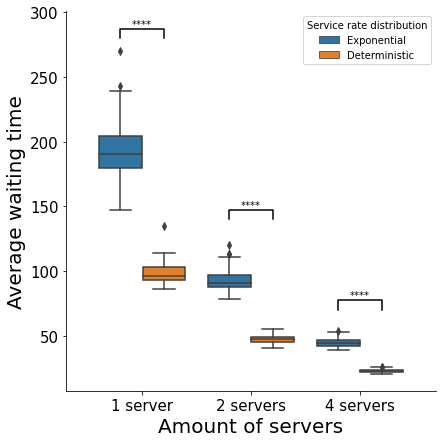

In [118]:
df_1_serverc = pd.DataFrame({'Waiting time': mean_waiting_timesc[0], 'Method': ['1 server' for i in range(len(mean_waiting_timesc[0]))], 'Service rate distribution': ['Deterministic' for i in range(len(mean_waiting_timesc[0]))]})
df_2_serverc = pd.DataFrame({'Waiting time': mean_waiting_timesc[1], 'Method': ['2 servers' for i in range(len(mean_waiting_timesc[1]))], 'Service rate distribution': ['Deterministic' for i in range(len(mean_waiting_timesc[0]))]})
df_3_serverc = pd.DataFrame({'Waiting time': mean_waiting_timesc[2], 'Method': ['4 servers' for i in range(len(mean_waiting_timesc[2]))], 'Service rate distribution': ['Deterministic' for i in range(len(mean_waiting_timesc[0]))]})


df_totalc = df_total.append(df_1_serverc)
df_totalc = df_totalc.append(df_2_serverc)
df_totalc = df_totalc.append(df_3_serverc)


p = sns.catplot(x="Method", y="Waiting time", hue = 'Service rate distribution', kind="box", data=df_totalc, height=6, aspect=8/8, legend_out = False)
# p = sns.swarmplot(x="Method", y="Waiting time", hue = 'service_distr', data=df_totalc, alpha = 0.5)

plt.xlabel("Amount of servers", size = 20)
plt.ylabel("Average waiting time", size = 20)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(ylabels, size=15)
p.set_xticklabels(xlabels, size=15)
# p.set(yscale="log")

x1, x2 = -0.2, 0.2   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = df_total['Waiting time'].max() + 10, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

x3, x4 = 0.8, 1.2   # columns '2 server' and '4 server' (first column: 0, see plt.xticks())
y1, h1, col = 140, 7.5, 'k'
# y1, h1, col = 1, 0.25, 'k'
plt.plot([x3, x3, x4, x4], [y1, y1+h1, y1+h1, y1], lw=1.5, c=col)
plt.text((x3+x4)*.5, y1+h1, "****", ha='center', va='bottom', color=col)

x3, x4 = 1.8, 2.2   # columns '2 server' and '4 server' (first column: 0, see plt.xticks())
y1, h1, col = 70, 7.5, 'k'
# y1, h1, col = 1, 0.25, 'k'
plt.plot([x3, x3, x4, x4], [y1, y1+h1, y1+h1, y1], lw=1.5, c=col)
plt.text((x3+x4)*.5, y1+h1, "****", ha='center', va='bottom', color=col)

plt.savefig('boxplots_service_distr.png', format='png', dpi=600, bbox_inches = "tight")


### Hyperexponential distribution

In [13]:
def source_long(env, number, lambda_1, counter, mu):
    """Source generates customers randomly"""
    for i in range(number):
        c = object_long(env, 'Customer%02d' % i, counter, mu)
        env.process(c)
        t = random.expovariate(lambda_1)     # Time before new customer arrives
        yield env.timeout(t)
        
        
def object_long(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
#     print('%7.4f %s: Here I am' % (arrive, name))
    with counter.request() as req:
        results = yield req
        wait = env.now - arrive
        waiting_times_long.append(wait)
        # We got to the counter
#         print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        rand_serv = random.random()
        if rand_serv < 0.75:
            tib = random.expovariate(mu[0])
        else:
            tib = random.expovariate(mu[1])
        yield env.timeout(tib)
#         print('%7.4f %s: Finished' % (env.now, name))

In [63]:
n_s = [1, 2, 4]                              # Number of servers
simulations = 100
mean_waiting_times_long = [[],[],[]]

start_time = time.time()

for n_ind in range(len(n_s)):
    n = n_s[n_ind]
    lambda_1 = arrival_rate = n/15              # Arrival rate, n/(inter arrival time)
    mu = [1/7, 1/35]                     # How much people one server can help for a given time period 
    number_of_arrivals = 10000000000
    print("\N{greek small letter rho} is: " + str(lambda_1/(n*(1/14))) + " with lambda: " +
          str(lambda_1) + " & mu: " + str(1/14) +  " for " + str(n) + " server(s).")
    for simulation in range(simulations):
#         print("Simulation: " + str(simulation))
        waiting_times_long = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n) 
        env.process(source_long(env,number_of_arrivals,lambda_1, server, mu))
        env.run(until=1000000)
        mean_waiting_times_long[n_ind].append(statistics.mean(waiting_times_long)) 
    print("Average waiting time: " + str(statistics.mean(mean_waiting_times_long[n_ind])) +
          " with sd: " + str(statistics.stdev(mean_waiting_times_long[n_ind])) + "\n")
    
end_time = time.time()
print("Running time: " + str(end_time - start_time))

ρ is: 0.9333333333333333 with lambda: 0.06666666666666667 & mu: 0.07142857142857142 for 1 server(s).
Average waiting time: 344.27778332372736 with sd: 51.42625504920781

ρ is: 0.9333333333333333 with lambda: 0.13333333333333333 & mu: 0.07142857142857142 for 2 server(s).
Average waiting time: 161.27978978184316 with sd: 16.856421908876133

ρ is: 0.9333333333333333 with lambda: 0.26666666666666666 & mu: 0.07142857142857142 for 4 server(s).
Average waiting time: 76.55530980326864 with sd: 7.137505475997058

Running time: 1796.7264077663422


In [143]:
for n_ind in range(len(mean_waiting_timesc)):
    print("Mean: " + str(statistics.mean(mean_waiting_timesc[n_ind])) +
          ". Upper limit: " + str(statistics.mean(mean_waiting_timesc[n_ind])+ 1.96*statistics.stdev(mean_waiting_timesc[n_ind])/len(mean_waiting_timesc[n_ind])**0.5) +
          ". Lower limit: " + str(statistics.mean(mean_waiting_timesc[n_ind])- 1.96*statistics.stdev(mean_waiting_timesc[n_ind])/len(mean_waiting_timesc[n_ind])**0.5) + "\n")

for n_ind in range(len(mean_waiting_times_long)):
    print("Mean: " + str(statistics.mean(mean_waiting_times_long[n_ind])) +
          ". Upper limit: " + str(statistics.mean(mean_waiting_times_long[n_ind])+ 1.96*statistics.stdev(mean_waiting_times_long[n_ind])/len(mean_waiting_times_long[n_ind])**0.5) +
          ". Lower limit: " + str(statistics.mean(mean_waiting_times_long[n_ind])- 1.96*statistics.stdev(mean_waiting_times_long[n_ind])/len(mean_waiting_times_long[n_ind])**0.5) + "\n")


statistic_1serverc = scipy.stats.shapiro(mean_waiting_times_long[0])
print(statistic_1serverc)
statistic_2serverc = scipy.stats.shapiro(mean_waiting_times_long[1])
print(statistic_2serverc)
statistic_3serverc = scipy.stats.shapiro(mean_waiting_times_long[2])
print(statistic_3serverc)

print(scipy.stats.mannwhitneyu(mean_waiting_times_long[0], mean_waiting_times[0]))
print(scipy.stats.mannwhitneyu(mean_waiting_times_long[1], mean_waiting_times[1]))
print(scipy.stats.mannwhitneyu(mean_waiting_times_long[2], mean_waiting_times[2]))

Mean: 98.14129374672586. Upper limit: 99.66358384447734. Lower limit: 96.61900364897438

Mean: 47.685370611115026. Upper limit: 48.300229540963244. Lower limit: 47.07051168126681

Mean: 22.8874596940379. Upper limit: 23.107788328243334. Lower limit: 22.667131059832467

Mean: 344.27778332372736. Upper limit: 354.3573293133721. Lower limit: 334.19823733408265

Mean: 161.27978978184316. Upper limit: 164.5836484759829. Lower limit: 157.97593108770343

Mean: 76.55530980326864. Upper limit: 77.95426087656406. Lower limit: 75.15635872997322

ShapiroResult(statistic=0.921330988407135, pvalue=1.6571093510719948e-05)
ShapiroResult(statistic=0.9919978976249695, pvalue=0.8210729956626892)
ShapiroResult(statistic=0.9253386855125427, pvalue=2.733212022576481e-05)
MannwhitneyuResult(statistic=1.0, pvalue=1.3201420157435136e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)
MannwhitneyuResult(statistic=0.0, pvalue=1.2810718345817004e-34)


C:\Users\flori\anaconda3\lib\site-packages\seaborn\axisgrid.py:923: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, **kwargs)


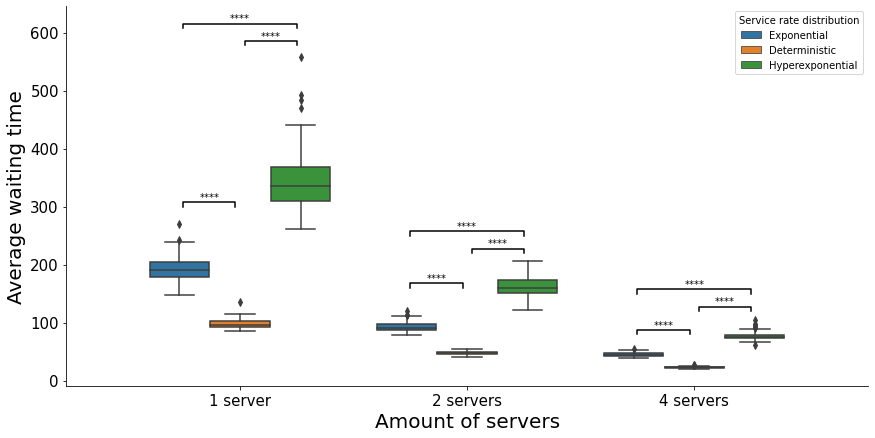

In [145]:
## Plotting the results as boxplots for different methods
df_1_server_long = pd.DataFrame({'Waiting time': mean_waiting_times_long[0], 'Method': ['1 server' for i in range(len(mean_waiting_times_long[0]))], 'Service rate distribution': ['Hyperexponential' for i in range(len(mean_waiting_times_long[0]))]})
df_2_server_long = pd.DataFrame({'Waiting time': mean_waiting_times_long[1], 'Method': ['2 servers' for i in range(len(mean_waiting_times_long[1]))], 'Service rate distribution': ['Hyperexponential' for i in range(len(mean_waiting_times_long[0]))]})
df_3_server_long = pd.DataFrame({'Waiting time': mean_waiting_times_long[2], 'Method': ['4 servers' for i in range(len(mean_waiting_times_long[2]))], 'Service rate distribution': ['Hyperexponential' for i in range(len(mean_waiting_times_long[0]))]})

df_total_long = df_totalc.append(df_1_server_long)
df_total_long = df_total_long.append(df_2_server_long)
df_total_long = df_total_long.append(df_3_server_long)

df_total_long_only = df_1_server_long.append(df_2_server_long)
df_total_long_only = df_total_long_only.append(df_3_server_long)

p = sns.catplot(x="Method", y="Waiting time", hue = "Service rate distribution", kind="box", data=df_total_long, height=6, aspect=12/6, legend_out = False)
# p = sns.swarmplot(x="Method", y="Waiting time", hue = 'service_distr', data=df_totalc, alpha = 0.5)

plt.xlabel("Amount of servers", size = 20)
plt.ylabel("Average waiting time", size = 20)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(ylabels, size=15)
p.set_xticklabels(xlabels, size=15)
# p.set(yscale="log")

x1, x2 = -0.25, -0.02   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = 300, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)
x1, x2 = 0.02, 0.25   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = df_total_long['Waiting time'].max() + 20, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)
x1, x2 = -0.25, 0.25   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = df_total_long['Waiting time'].max() + 50, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

x1, x2 = 0.75, 0.98   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = 160, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)
x1, x2 = 1.02, 1.25   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = 220, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)
x1, x2 = 0.75, 1.25   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = 220+30, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

x1, x2 = 1.75, 1.98   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = 80, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)
x1, x2 = 2.02, 2.25   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = 120, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)
x1, x2 = 1.75, 2.25   # columns '1 server' and '2 server' (first column: 0, see plt.xticks())
y, h, col = 120+30, 7.5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

plt.savefig('boxplots_service_distr_longtail.png', format='png', dpi=600, bbox_inches = "tight")
